In [1]:
using Cropbox

In [2]:
new_install = false
if new_install
    import Pkg

    Pkg.add("CSV")
    Pkg.add("DataFrames")
    Pkg.add("DataFramesMeta")
    Pkg.add("Statistics")    
    Pkg.add("GLM")
end

In [3]:
using CSV
using DataFrames
using DataFramesMeta
using Statistics
using GLM

In [4]:
import Gadfly
import Cairo

In [5]:
using Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

## Dataset

We have two datasets from an experiment conducted in 2005 with maize plots under multiple levels of nitrogen application.

- `corn2005spad.csv`: overal growth data including SPAD
- `corn2005ge.csv`: corresponding gas exchange measurements from LI-COR

### SPAD

In [6]:
obs_spad = CSV.read("corn2005spad.csv", DataFrame) |> unitfy

18×15 DataFrame
 Row │ date     nitrogen      plot   subplot  row    leaf_rank  SPAD     LA    ⋯
     │ String7  Quantity…     Int64  String1  Int64  Int64      Float64  Quant ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 7/19/05   60 kg ha^-1      1  B            3         14     44.9  172.9 ⋯
   2 │ 7/28/05   60 kg ha^-1      1  J            1         14     44.3  160.2
   3 │ 7/19/05    0 kg ha^-1      2  B            2         12     40.3  176.1
   4 │ 7/28/05    0 kg ha^-1      2  J            1         13     33.1  105.6
   5 │ 7/19/05  240 kg ha^-1      3  B            2         13     58.8  105.5 ⋯
   6 │ 7/28/05  240 kg ha^-1      3  J            1         14     56.6  148.4
   7 │ 7/20/05    0 kg ha^-1      4  B            4         13     28.8  105.4
   8 │ 7/29/05    0 kg ha^-1      4  J            1         13     31.2  120.8
   9 │ 7/20/05  240 kg ha^-1      5  B            2         14     60.8  138.9 ⋯
  10 │ 8/2/05   240 kg ha^-1      5  J            1         14     55.4  115.7
  11 │ 7/20/05   60 kg ha^-1      6  B            2         13     49.1  146.1
  12 │ 8/2/05    60 kg ha^-1      6  J            1         14     41.8  132.6
  13 │ 7/22/05  240 kg ha^-1      7  B            2         13     56.8  139.1 ⋯
  14 │ 8/3/05   240 kg ha^-1      7  J            1         14     61.9  161.9
  15 │ 7/22/05   60 kg ha^-1      8  B            3         14     37.3  110.2
  16 │ 8/3/05    60 kg ha^-1      8  J            1         15     47.8  156.0
  17 │ 7/22/05    0 kg ha^-1      9  B            2         13     38.5  152.7 ⋯
  18 │ 8/3/05     0 kg ha^-1      9  J            1         14     37.3  152.5
                                                               8 columns omitted

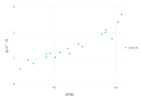

In [7]:
plot(obs_spad, :SPAD, :leaf_N, kind=:scatter)

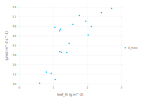

In [8]:
plot(obs_spad, :leaf_N, :A_max, kind=:scatter)

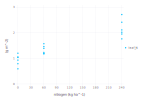

In [9]:
plot(obs_spad, :nitrogen, :leaf_N, kind=:scatter)

### Gas Exchange

In [10]:
obs_ge = CSV.read("corn2005ge.csv", DataFrame) |> unitfy;

Recalculate stomatal conductance in units that our model uses for taking account air pressure.

In [11]:
obs_ge.gs_o = obs_ge.Cond ./ obs_ge.Press .|> u"mol/m^2/s/bar";

Make a combined dataset.

In [12]:
obs = innerjoin(obs_ge, obs_spad, on=[:plot, :subplot], makeunique=true);

## Model

Gas exchange model is mostly derived from MAIZSIM, adapting to Cropbox framework.

### SPAD - N

In [13]:
@system Nitrogen begin
    SPAD: SPAD_greenness ~ preserve(parameter)
    SNa: SPAD_N_coeff_a ~ preserve(u"g/m^2", parameter)
    SNb: SPAD_N_coeff_b ~ preserve(u"g/m^2", parameter)
    SNc: SPAD_N_coeff_c ~ preserve(u"g/m^2", parameter)
    N(SPAD, a=SNa, b=SNb, c=SNc): leaf_nitrogen_content => begin
        a*SPAD^2 + b*SPAD + c
    end ~ preserve(u"g/m^2", parameter)
    Np(N, SLA) => N * SLA ~ track(u"percent")
    SLA: specific_leaf_area => 200 ~ preserve(u"cm^2/g")
end

Nitrogen

In [14]:
@system NitrogenController(Nitrogen, Controller)

NitrogenController

In [15]:
spad_configs = [:Nitrogen => :SPAD => x for x in obs_spad.SPAD]

18-element Vector{Pair{Symbol, Pair{Symbol, Float64}}}:
 :Nitrogen => (:SPAD => 44.9)
 :Nitrogen => (:SPAD => 44.3)
 :Nitrogen => (:SPAD => 40.3)
 :Nitrogen => (:SPAD => 33.1)
 :Nitrogen => (:SPAD => 58.8)
 :Nitrogen => (:SPAD => 56.6)
 :Nitrogen => (:SPAD => 28.8)
 :Nitrogen => (:SPAD => 31.2)
 :Nitrogen => (:SPAD => 60.8)
 :Nitrogen => (:SPAD => 55.4)
 :Nitrogen => (:SPAD => 49.1)
 :Nitrogen => (:SPAD => 41.8)
 :Nitrogen => (:SPAD => 56.8)
 :Nitrogen => (:SPAD => 61.9)
 :Nitrogen => (:SPAD => 37.3)
 :Nitrogen => (:SPAD => 47.8)
 :Nitrogen => (:SPAD => 38.5)
 :Nitrogen => (:SPAD => 37.3)

In [16]:
nitrogen_config = :Nitrogen => (SNa=0.0004, SNb=0.0120, SNc=0)

:Nitrogen => (SNa = 0.0004, SNb = 0.012, SNc = 0)

We have a quadratic relationship $N = 0.0004S^2 + 0.0120S$. Note that intercept (`SNc`) is close to zero.

In [17]:
est = simulate(NitrogenController, [(index=:SPAD, target=:N)], [(c, nitrogen_config) for c in spad_configs])[1]

Progress: 100%[=========================================] Time: 0:00:01


18×2 DataFrame
 Row │ SPAD     N
     │ Float64  Quantity…
─────┼──────────────────────────
   1 │    44.9    1.3452 g m^-2
   2 │    44.3    1.3166 g m^-2
   3 │    40.3   1.13324 g m^-2
   4 │    33.1  0.835444 g m^-2
   5 │    58.8   2.08858 g m^-2
   6 │    56.6   1.96062 g m^-2
   7 │    28.8  0.677376 g m^-2
   8 │    31.2  0.763776 g m^-2
   9 │    60.8   2.20826 g m^-2
  10 │    55.4   1.89246 g m^-2
  11 │    49.1   1.55352 g m^-2
  12 │    41.8    1.2005 g m^-2
  13 │    56.8    1.9721 g m^-2
  14 │    61.9   2.27544 g m^-2
  15 │    37.3   1.00412 g m^-2
  16 │    47.8   1.48754 g m^-2
  17 │    38.5    1.0549 g m^-2
  18 │    37.3   1.00412 g m^-2

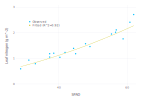

In [18]:
p = plot(obs_spad, :SPAD, :leaf_N, ylab="Leaf nitrogen", name="Observed", legendpos=(0.1,-0.3), kind=:scatter)
plot!(p, est, :SPAD, :N, name="Fitted (R^2=0.92)", kind=:line)
p' |> Gadfly.PDF("SPAD-N.pdf")
p

In [19]:
lm(@formula(est ~ obs), DataFrame(obs=deunitfy(obs_spad.leaf_N), est=deunitfy(est.N))) |> r2

0.9188373992703252

### Environment

In [20]:
@system VaporPressure begin
    a => 0.611 ~ preserve(u"kPa", parameter)
    b => 17.502 ~ preserve(parameter)
    c => 240.97 ~ preserve(parameter)

    es(a, b, c; T(u"°C")): saturation => (t = deunitfy(T); a*exp((b*t)/(c+t))) ~ call(u"kPa")
    ea(es; T(u"°C"), RH(u"percent")): ambient => es(T) * RH ~ call(u"kPa")
    D(es; T(u"°C"), RH(u"percent")): deficit => es(T) * (1 - RH) ~ call(u"kPa")
    RH(es; T(u"°C"), VPD(u"kPa")): relative_humidity => 1 - VPD / es(T) ~ call(u"NoUnits")

    Δ(es, b, c; T(u"°C")): saturation_slope_delta => (e = es(T); t = deunitfy(T); e*(b*c)/(c+t)^2 / u"K") ~ call(u"kPa/K")
    s(Δ; T(u"°C"), P(u"kPa")): saturation_slope => Δ(T) / P ~ call(u"K^-1")
end

VaporPressure

In [21]:
@system Weather begin
    vp(context): vapor_pressure ~ ::VaporPressure

    PFD: photon_flux_density ~ preserve(u"μmol/m^2/s", parameter)
    CO2: carbon_dioxide ~ preserve(u"μmol/mol", parameter)
    RH: relative_humidity ~ preserve(u"percent", parameter)
    T_air: air_temperature ~ preserve(u"°C", parameter)
    Tk_air(T_air): absolute_air_temperature ~ track(u"K")
    wind: wind_speed ~ preserve(u"m/s", parameter)
    P_air: air_pressure => 100 ~ preserve(u"kPa", parameter)

    VPD(T_air, RH, D=vp.D): vapor_pressure_deficit => D(T_air, RH) ~ track(u"kPa")
    VPD_Δ(T_air, Δ=vp.Δ): vapor_pressure_saturation_slope_delta => Δ(T_air) ~ track(u"kPa/K")
    VPD_s(T_air, P_air, s=vp.s): vapor_pressure_saturation_slope => s(T_air, P_air) ~ track(u"K^-1")
end

Weather

In [22]:
@system Diffusion begin
    Dw: diffusion_coeff_for_water_vapor_in_air_at_20 => 24.2 ~ preserve(u"mm^2/s", parameter)
    Dc: diffusion_coeff_for_co2_in_air_at_20 => 14.7 ~ preserve(u"mm^2/s", parameter)
    Dh: diffusion_coeff_for_heat_in_air_at_20 => 21.5 ~ preserve(u"mm^2/s", parameter)
    Dm: diffusion_coeff_for_momentum_in_air_at_20 => 15.1 ~ preserve(u"mm^2/s", parameter)
end

Diffusion

In [23]:
@system Irradiance begin
    PFD ~ hold
    PPFD(PFD): photosynthetic_photon_flux_density ~ track(u"μmol/m^2/s")

    δ: leaf_scattering => 0.15 ~ preserve(parameter)
    f: leaf_spectral_correction => 0.15 ~ preserve(parameter)

    Ia(PPFD, δ): absorbed_irradiance => begin
        PPFD * (1 - δ)
    end ~ track(u"μmol/m^2/s")

    I2(Ia, f): effective_irradiance => begin
        Ia * (1 - f) / 2
    end ~ track(u"μmol/m^2/s")
end

Irradiance

### C4

In [24]:
@system TemperatureDependence begin
    T: leaf_temperature ~ hold
    Tk(T): absolute_leaf_temperature ~ track(u"K")

    Tb: base_temperature => 25 ~ preserve(u"°C", parameter)
    Tbk(Tb): absolute_base_temperature ~ preserve(u"K")

    kT(T, Tk, Tb, Tbk; Ea(u"kJ/mol")): arrhenius_equation => begin
        exp(Ea * (T - Tb) / (u"R" * Tk * Tbk))
    end ~ call

    kTpeak(Tk, Tbk, kT; Ea(u"kJ/mol"), S(u"J/mol/K"), H(u"kJ/mol")): peaked_function => begin
        R = u"R"
        kT(Ea) * (1 + exp((S*Tbk - H) / (R*Tbk))) / (1 + exp((S*Tk - H) / (R*Tk)))
    end ~ call

    Q10 => 2 ~ preserve(parameter)
    kTQ10(T, Tb, Q10): q10_rate => begin
        Q10^((T - Tb) / 10u"K")
    end ~ track
end

TemperatureDependence

In [25]:
@system NitrogenDependence begin
    N: leaf_nitrogen_content ~ hold

    s => 2.9 ~ preserve(u"m^2/g", parameter)
    N0 => 0.25 ~ preserve(u"g/m^2", parameter)

    kN(N, s, N0): nitrogen_limited_rate => begin
        2 / (1 + exp(-s * (max(N0, N) - N0))) - 1
    end ~ track
end

NitrogenDependence

In [26]:
@system CBase(TemperatureDependence, NitrogenDependence) begin
    Ci: intercellular_co2 ~ hold
    I2: effective_irradiance ~ hold
end

CBase

In [27]:
@system C4Base(CBase) begin
    Cm(Ci): mesophyll_co2 ~ track(u"μbar")
    gbs: bundle_sheath_conductance => 0.003 ~ preserve(u"mol/m^2/s/bar", parameter)
end

C4Base

In [28]:
@system C4c(C4Base) begin
    Kp25: pep_carboxylase_constant_for_co2_at_25 => 80 ~ preserve(u"μbar", parameter)
    Kp(Kp25, kTQ10): pep_carboxylase_constant_for_co2 => begin
        Kp25 * kTQ10
    end ~ track(u"μbar")

    Vpm25: maximum_pep_carboxylation_rate_for_co2_at_25 => 70 ~ preserve(u"μmol/m^2/s", parameter)
    EaVp: activation_energy_for_pep_carboxylation => 75.1 ~ preserve(u"kJ/mol", parameter)
    Vpmax(Vpm25, kT, EaVp, kN): maximum_pep_carboxylation_rate => begin
        Vpm25 * kT(EaVp) * kN
    end ~ track(u"μmol/m^2/s")

    Vpr25: regeneration_limited_pep_carboxylation_rate_for_co2_at_25 => 80 ~ preserve(u"μmol/m^2/s", parameter)
    Vpr(Vpr25, kTQ10): regeneration_limited_pep_carboxylation_rate => begin
        Vpr25 * kTQ10
    end ~ track(u"μmol/m^2/s")
    Vp(Vpmax, Vpr, Cm, Kp): pep_carboxylation_rate => begin
        (Cm * Vpmax) / (Cm + Kp)
    end ~ track(u"μmol/m^2/s", max=Vpr)

    Vcm25: maximum_carboxylation_rate_at_25 => 50 ~ preserve(u"μmol/m^2/s", parameter)
    EaVc: activation_energy_for_carboxylation => 55.9 ~ preserve(u"kJ/mol", parameter)
    Vcmax(Vcm25, kT, EaVc, kN): maximum_carboxylation_rate => begin
        Vcm25 * kT(EaVc) * kN
    end ~ track(u"μmol/m^2/s")
end

C4c

In [29]:
@system C4j(C4Base) begin
    Jm25: maximum_electron_transport_rate_at_25 => 300 ~ preserve(u"μmol/m^2/s", parameter)
    Eaj: activation_energy_for_electron_transport => 32.8 ~ preserve(u"kJ/mol", parameter)
    Sj: electron_transport_temperature_response => 702.6 ~ preserve(u"J/mol/K", parameter)
    Hj: electron_transport_curvature => 220 ~ preserve(u"kJ/mol", parameter)
    Jmax(Jm25, kTpeak, Eaj, Sj, Hj, kN): maximum_electron_transport_rate => begin
        Jm25 * kTpeak(Eaj, Sj, Hj) * kN
    end ~ track(u"μmol/m^2/s")

    θ: light_transition_sharpness => 0.5 ~ preserve(parameter)
    J(I2, Jmax, θ): electron_transport_rate => begin
        a = θ
        b = -(I2+Jmax)
        c = I2*Jmax
        a*J^2 + b*J + c ⩵ 0
    end ~ solve(lower=0, upper=Jmax, u"μmol/m^2/s")
end

C4j

In [30]:
@system C4r(C4Base) begin
    Kc25: rubisco_constant_for_co2_at_25 => 650 ~ preserve(u"μbar", parameter)
    Eac: activation_energy_for_co2 => 59.4 ~ preserve(u"kJ/mol", parameter)
    Kc(kT, Kc25, Eac): rubisco_constant_for_co2 => begin
        Kc25 * kT(Eac)
    end ~ track(u"μbar")

    Ko25: rubisco_constant_for_o2_at_25 => 450 ~ preserve(u"mbar", parameter)
    # Activation energy for Ko, Bernacchi (2001)
    Eao: activation_energy_for_o2 => 36 ~ preserve(u"kJ/mol", parameter)
    Ko(Ko25, kT, Eao): rubisco_constant_for_o2 => begin
        Ko25 * kT(Eao)
    end ~ track(u"mbar")

    Om: mesophyll_o2_partial_pressure => 210 ~ preserve(u"mbar", parameter)
    Km(Kc, Om, Ko): rubisco_constant_for_co2_with_o2 => begin
        Kc * (1 + Om / Ko)
    end ~ track(u"μbar")

    Rd25: dark_respiration_at_25 => 2 ~ preserve(u"μmol/m^2/s", parameter)
    Ear: activation_energy_for_respiration => 39.8 ~ preserve(u"kJ/mol", parameter)
    Rd(Rd25, kT, Ear): dark_respiration => begin
        Rd25 * kT(Ear)
    end ~ track(u"μmol/m^2/s")
    Rm(Rd) => 0.5Rd ~ track(u"μmol/m^2/s")
end

C4r

In [31]:
@system C4Rate(C4c, C4j, C4r) begin
    Ac1(Vp, gbs, Cm, Rm) => (Vp + gbs*Cm - Rm) ~ track(u"μmol/m^2/s")
    Ac2(Vcmax, Rd) => (Vcmax - Rd) ~ track(u"μmol/m^2/s")
    Ac(Ac1, Ac2): enzyme_limited_photosynthesis_rate => begin
        min(Ac1, Ac2)
    end ~ track(u"μmol/m^2/s")

    x: electron_transport_partitioning_factor => 0.4 ~ preserve(parameter)
    Aj1(x, J, Rm, gbs, Cm) => (x * J/2 + gbs*Cm - Rm) ~ track(u"μmol/m^2/s")
    Aj0(x, J, Rm, gbs, Cm) => (x * J/2 - gbs*Cm - Rm) ~ track(u"μmol/m^2/s")
    Aj2(x, J, Rd) => (1-x) * J/3 - Rd ~ track(u"μmol/m^2/s")
    Aj(Aj1, Aj2): transport_limited_photosynthesis_rate => begin
        min(Aj1, Aj2)
    end ~ track(u"μmol/m^2/s")

    β: photosynthesis_transition_factor => 0.99 ~ preserve(parameter)
    A_net(Ac, Aj, β): net_photosynthesis => begin
        x = A_net
        a = β
        b = -(Ac+Aj)
        c = Ac*Aj
        a*x^2 + b*x + c ⩵ 0
    end ~ solve(pick=:minimum, u"μmol/m^2/s")

    A_gross(A_net, Rd): gross_photosynthesis => begin
        A_gross = A_net + Rd
    end ~ track(u"μmol/m^2/s")
end

C4Rate

In [32]:
@system C4(C4Rate)

C4

### Interface

#### Boundary Layer

In [33]:
@system BoundaryLayer(Weather, Diffusion) begin
    w: leaf_width => 10 ~ preserve(u"cm", parameter)

    sr: stomatal_ratio => 1.0 ~ preserve(parameter)
    scr(sr): sides_conductance_ratio => ((sr + 1)^2 / (sr^2 + 1)) ~ preserve
    ocr: outdoor_conductance_ratio => 1.4 ~ preserve

    u(u=wind): wind_velocity ~ track(u"m/s", min=0.1)
    d(w): characteristic_dimension => 0.72w ~ track(u"m")
    v(Dm): kinematic_viscosity_of_air ~ preserve(u"m^2/s", parameter)
    κ(Dh): thermal_diffusivity_of_air ~ preserve(u"m^2/s", parameter)
    Re(u, d, v): reynolds_number => u*d/v ~ track
    Nu(Re): nusselt_number => 0.60sqrt(Re) ~ track
    gh(κ, Nu, d, scr, ocr, P_air, Tk_air): boundary_layer_heat_conductance => begin
        g = κ * Nu / d
        g *= scr * ocr
        g * P_air / (u"R" * Tk_air)
    end ~ track(u"mmol/m^2/s")
    rhw(Dw, Dh): ratio_from_heat_to_water_vapor => (Dw / Dh)^(2/3) ~ preserve
    gb(rhw, gh, P_air): boundary_layer_conductance => rhw * gh / P_air ~ track(u"mol/m^2/s/bar")
end

BoundaryLayer

#### Stomata

In [34]:
@system StomataBase(Weather, Diffusion) begin
    gs: stomatal_conductance ~ hold
    gb: boundary_layer_conductance ~ hold
    A_net: net_photosynthesis ~ hold
    T: leaf_temperature ~ hold

    drb(Dw, Dc): diffusivity_ratio_boundary_layer => (Dw / Dc)^(2/3) ~ preserve(parameter)
    dra(Dw, Dc): diffusivity_ratio_air => (Dw / Dc) ~ preserve(parameter)

    Ca(CO2, P_air): co2_air => (CO2 * P_air) ~ track(u"μbar")
    Cs(Ca, A_net, gbc): co2_at_leaf_surface => begin
        Ca - A_net / gbc
    end ~ track(u"μbar")

    gv(gs, gb): total_conductance_h2o => (gs * gb / (gs + gb)) ~ track(u"mol/m^2/s/bar")

    rbc(gb, drb): boundary_layer_resistance_co2 => (drb / gb) ~ track(u"m^2*s/mol*bar")
    rsc(gs, dra): stomatal_resistance_co2 => (dra / gs) ~ track(u"m^2*s/mol*bar")
    rvc(rbc, rsc): total_resistance_co2 => (rbc + rsc) ~ track(u"m^2*s/mol*bar")

    gbc(rbc): boundary_layer_conductance_co2 => (1 / rbc) ~ track(u"mol/m^2/s/bar")
    gsc(rsc): stomatal_conductance_co2 => (1 / rsc) ~ track(u"mol/m^2/s/bar")
    gvc(rvc): total_conductance_co2 => (1 / rvc) ~ track(u"mol/m^2/s/bar")
end

StomataBase

In [35]:
@system StomataTuzet begin
    WP_leaf: leaf_water_potential => 0 ~ preserve(u"MPa", parameter)
    Ψv(WP_leaf): bulk_leaf_water_potential ~ track(u"MPa")
    Ψf: reference_leaf_water_potential => -1.2 ~ preserve(u"MPa", parameter)
    sf: stomata_sensitivity_param => 2.3 ~ preserve(u"MPa^-1", parameter)
    fΨv(Ψv, Ψf, sf): stomata_sensitivty => begin
        (1 + exp(sf*Ψf)) / (1 + exp(sf*(Ψf-Ψv)))
    end ~ track
end

StomataTuzet

##### Ball-Berry Model

In [36]:
@system StomataBallBerry(StomataBase, StomataTuzet) begin
    g0 => 0.017 ~ preserve(u"mol/m^2/s/bar", parameter)
    g1 => 4.53 ~ preserve(parameter)

    hs(g0, g1, gb, A_net, Cs, fΨv, RH): relative_humidity_at_leaf_surface => begin
        gs = g0 + g1*(A_net*hs/Cs) * fΨv
        (hs - RH)*gb ⩵ (1 - hs)*gs
    end ~ solve(lower=0, upper=1)
    Ds(D=vp.D, T, hs): vapor_pressure_deficit_at_leaf_surface => begin
        D(T, hs)
    end ~ track(u"kPa")

    gs(g0, g1, A_net, hs, Cs, fΨv): stomatal_conductance => begin
        g0 + g1*(A_net*hs/Cs) * fΨv
    end ~ track(u"mol/m^2/s/bar", min=g0)
end

StomataBallBerry

##### Medlyn Model

In [37]:
@system StomataMedlyn(StomataBase, StomataTuzet) begin
    g0 => 0.02 ~ preserve(u"mol/m^2/s/bar", parameter)
    g1 => 4.0 ~ preserve(u"√kPa", parameter)

    wa(ea=vp.ea, T_air, RH): vapor_pressure_at_air => ea(T_air, RH) ~ track(u"kPa")
    wi(es=vp.es, T): vapor_pressure_at_intercellular_space => es(T) ~ track(u"kPa")
    ws(Ds, wi): vapor_pressure_at_leaf_surface => (wi - Ds) ~ track(u"kPa")
    Ds¹ᐟ²(g0, g1, gb, A_net, Cs, fΨv, wi, wa) => begin
        gs = g0 + (1 + g1 / Ds¹ᐟ²) * (A_net / Cs) * fΨv
        ws = wi - Ds¹ᐟ²^2
        (ws - wa)*gb ⩵ (wi - ws)*gs
    end ~ solve(lower=0, upper=√wi', u"√kPa")
    Ds(Ds¹ᐟ²): vapor_pressure_deficit_at_leaf_surface => Ds¹ᐟ²^2 ~ track(u"kPa", min=1u"Pa")
    hs(RH=vp.RH, T, Ds): relative_humidity_at_leaf_surface => RH(T, Ds) ~ track

    gs(g0, g1, A_net, Ds, Cs, fΨv): stomatal_conductance => begin
        g0 + (1 + g1/√Ds)*(A_net/Cs) * fΨv
    end ~ track(u"mol/m^2/s/bar", min=g0)
end

StomataMedlyn

#### Intercellular Space

In [38]:
@system IntercellularSpace(Weather) begin
    A_net ~ hold
    gvc ~ hold

    Ca(CO2, P_air): co2_air => (CO2 * P_air) ~ track(u"μbar")
    Cimax(Ca): intercellular_co2_upper_limit => 2Ca ~ track(u"μbar")
    Cimin: intercellular_co2_lower_limit => 0 ~ preserve(u"μbar")
    Ci(Ca, Ci, A_net, gvc): intercellular_co2 => begin
        Ca - Ci ⩵ A_net / gvc
    end ~ bisect(min=Cimin, upper=Cimax, u"μbar")
end

IntercellularSpace

### Energy Balance

In [39]:
@system EnergyBalance(Weather) begin
    gv ~ hold
    gh ~ hold
    PPFD ~ hold

    ϵ: leaf_thermal_emissivity => 0.97 ~ preserve(parameter)
    σ: stefan_boltzmann_constant => u"σ" ~ preserve(u"W/m^2/K^4")
    λ: latent_heat_of_vaporization_at_25 => 44 ~ preserve(u"kJ/mol", parameter)
    Cp: specific_heat_of_air => 29.3 ~ preserve(u"J/mol/K", parameter)

    k: radiation_conversion_factor => (1 / 4.55) ~ preserve(u"J/μmol")
    α_s: absorption_coefficient => 0.79 ~ preserve(parameter)
    PAR(PPFD, k): photosynthetically_active_radiation => (PPFD * k) ~ track(u"W/m^2")
    R_sw(PAR, α_s): shortwave_radiation_absorbed => (α_s * PAR) ~ track(u"W/m^2")

    R_wall(ϵ, σ, Tk_air): thermal_radiation_absorbed_from_wall => 2ϵ*σ*Tk_air^4 ~ track(u"W/m^2")
    R_leaf(ϵ, σ, Tk): thermal_radiation_emitted_by_leaf => 2ϵ*σ*Tk^4 ~ track(u"W/m^2")
    R_thermal(R_wall, R_leaf): thermal_radiation_absorbed => R_wall - R_leaf ~ track(u"W/m^2")
    R_net(R_sw, R_thermal): net_radiation_absorbed => R_sw + R_thermal ~ track(u"W/m^2")

    Δw(T, T_air, RH, ea=vp.ambient, es=vp.saturation): leaf_vapor_pressure_gradient => begin
        es(T) - ea(T_air, RH)
    end ~ track(u"kPa")
    E(gv, Δw): transpiration => gv*Δw ~ track(u"mmol/m^2/s")

    H(Cp, gh, ΔT): sensible_heat_flux => Cp*gh*ΔT ~ track(u"W/m^2")
    λE(λ, E): latent_heat_flux => λ*E ~ track(u"W/m^2")

    ΔT(R_net, H, λE): temperature_adjustment => begin
        R_net ⩵ H + λE
    end ~ bisect(lower=-10, upper=10, u"K", evalunit=u"W/m^2")

    T(T_air, ΔT): leaf_temperature => (T_air + ΔT) ~ track(u"°C")
    Tk(T): absolute_leaf_temperature ~ track(u"K")
end

EnergyBalance

### Coupling

In [40]:
abstract type GasExchange <: System end

In [41]:
@system GasExchangeBallBerry(
    Weather, Nitrogen,
    BoundaryLayer, StomataBallBerry, IntercellularSpace, Irradiance, EnergyBalance,
    C4, Controller
) <: GasExchange

GasExchangeBallBerry

In [42]:
@system GasExchangeMedlyn(
    Weather, Nitrogen,
    BoundaryLayer, StomataMedlyn, IntercellularSpace, Irradiance, EnergyBalance,
    C4, Controller
) <: GasExchange

GasExchangeMedlyn

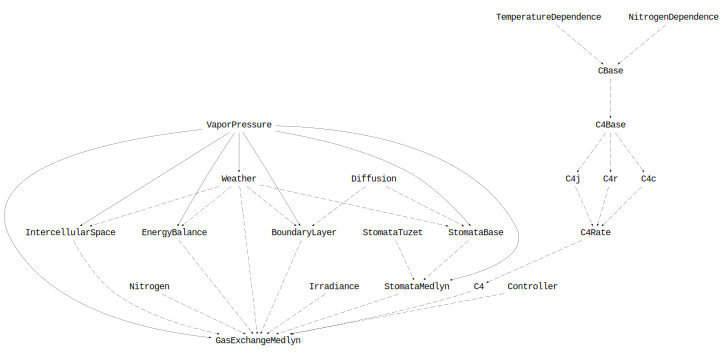

In [43]:
h = Cropbox.hierarchy(GasExchangeMedlyn; skipcontext=true)
Cropbox.writeimage("GasExchangeMedlyn.pdf", h)
h

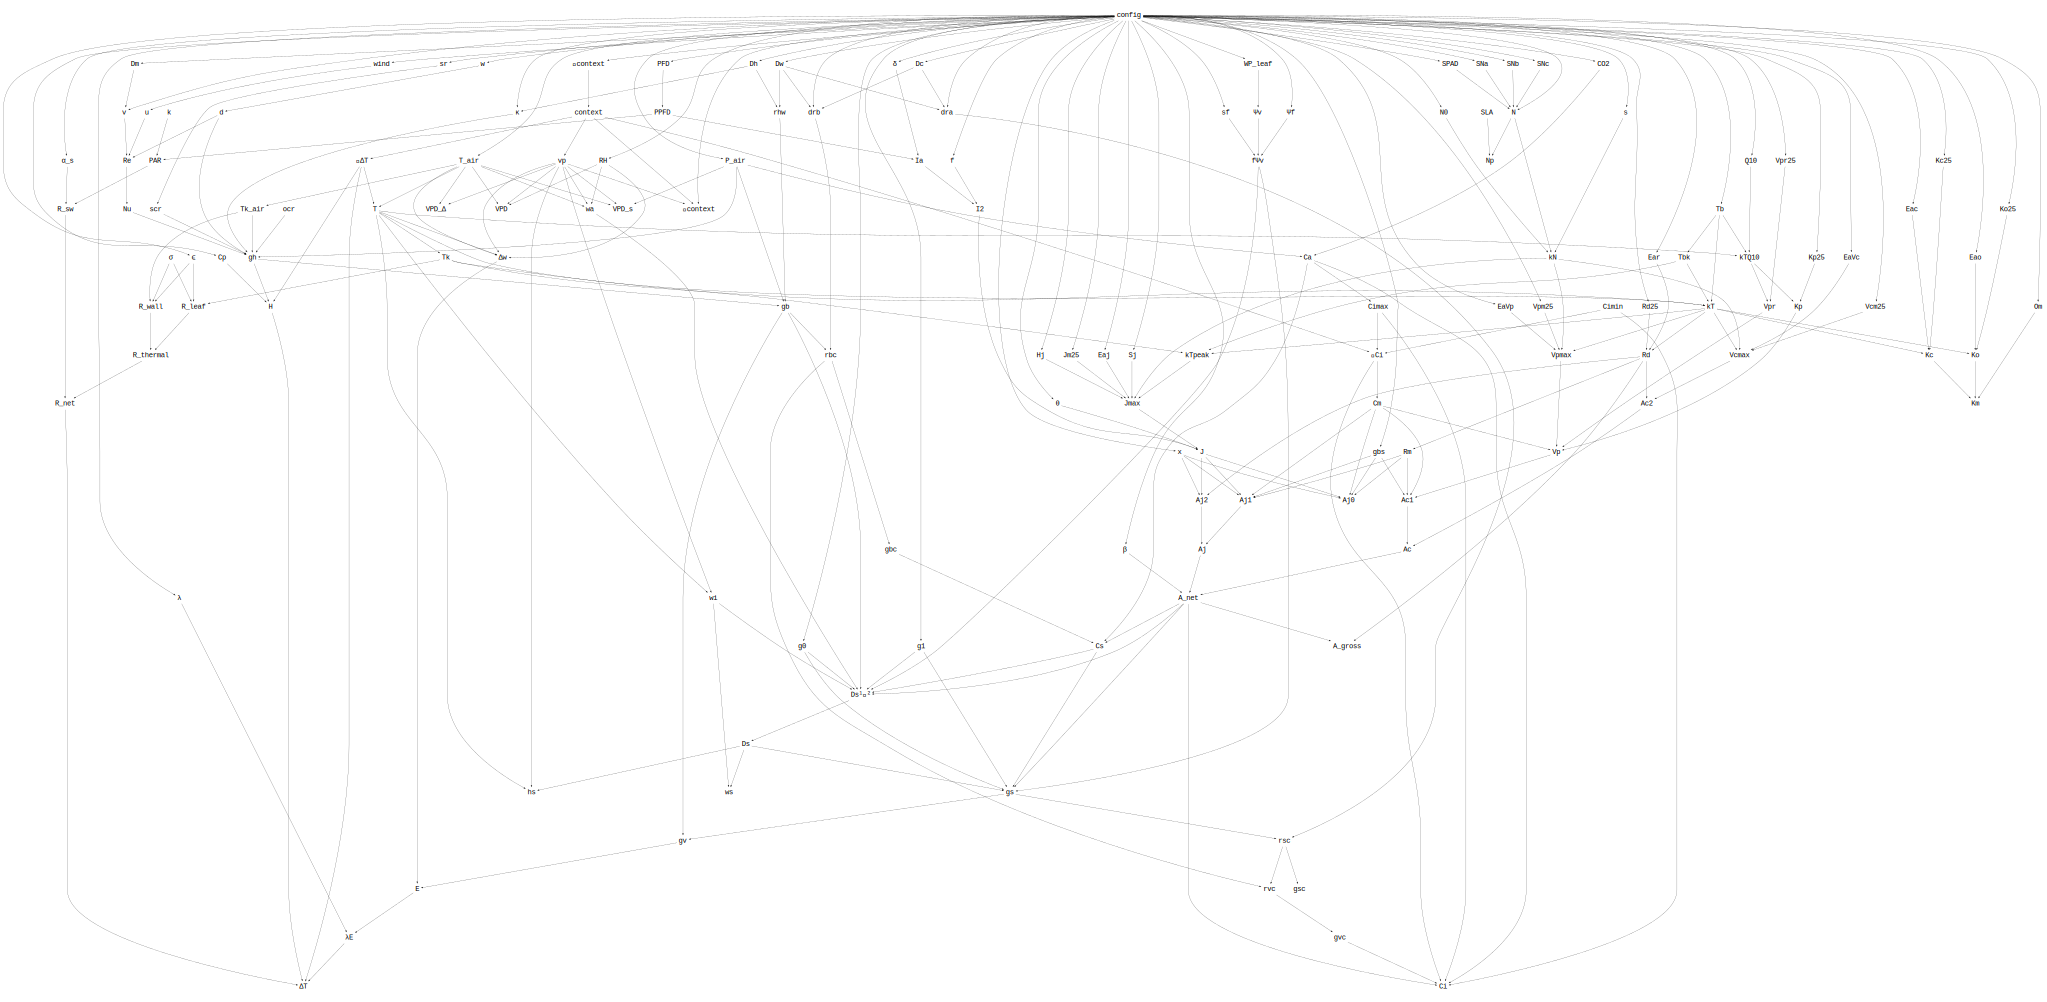

In [44]:
d = Cropbox.dependency(GasExchangeMedlyn)

Default parameters are mostly from MAIZSIM.

In [45]:
parameters(C4)

Config for 1 system:
  C4
    Tb    = 25 °C
    Q10   = 2
    s     = 2.9 m^2 g^-1
    N0    = 0.25 g m^-2
    gbs   = 0.003 mol bar^-1 m^-2 s^-1
    Kp25  = 80 μbar
    Vpm25 = 70 μmol m^-2 s^-1
    EaVp  = 75.1 kJ mol^-1
    Vpr25 = 80 μmol m^-2 s^-1
    Vcm25 = 50 μmol m^-2 s^-1
    EaVc  = 55.9 kJ mol^-1
    Jm25  = 300 μmol m^-2 s^-1
    Eaj   = 32.8 kJ mol^-1
    Sj    = 702.6 J K^-1 mol^-1
    Hj    = 220 kJ mol^-1
    θ     = 0.5
    Kc25  = 650 μbar
    Eac   = 59.4 kJ mol^-1
    Ko25  = 450 mbar
    Eao   = 36 kJ mol^-1
    Om    = 210 mbar
    Rd25  = 2 μmol m^-2 s^-1
    Ear   = 39.8 kJ mol^-1
    x     = 0.4
    β     = 0.99

For simplicity, environmental inputs are set as parameters, instead of driving variables loaded from external data frame.

In [46]:
base_config = (
    nitrogen_config,
    :Nitrogen => (
        SPAD = 60,
    ),
    :Weather => (
        PFD = 2000,
        CO2 = 400,
        RH = 66,
        T_air = 32,
        wind = 2.0,
        P_air = 99.4,
    ),
);

## Calibration

Since our model generally performed well under nitrogen non-limiting condition, we decided to keep the most of existing parameter set and calibrate only a small set of parameters. We will calibrate two parameters (`s`, `N0`) for nitrogen dependency along `A_net` and two parameters (`g0`, `g1`) for stomatal conductance along `gs`.

In [47]:
obs_configs = [(
    nitrogen_config,
    :Nitrogen => (
        SPAD = r[:SPAD],
    ),
    :Weather => (
        PFD = r[:PARi],
        CO2 = r[:CO2S],
        RH = r[:RH_S],
        T_air = r[:Tair],
        wind = 2.0,
        P_air = r[:Press],
    ),
) for r in eachrow(obs)];

In [48]:
# bb_calib_config = calibrate(GasExchangeBallBerry, obs, obs_configs;
#     index=[:PARi => :PFD, :CO2S => :CO2, :RH_S => :RH, :Tair => :T_air, :Press => :P_air, :SPAD],
#     target=[:Photo => :A_net, :gs],
#     parameters=(
#         :NitrogenDependence => (s=(0, 10), N0=(0, 1)),
#         :StomataBallBerry => (g0=(0, 1), g1=(0, 10)),
#     ),
#     skipfirst=true,
#     optim=(
#         MaxSteps=2000,
#         TraceInterval=10,
#         RandomizeRngSeed=false,
#     ),
#     metric=:prmse,
#     #weight=[1, 100],
#     #pareto=true
# )

In [49]:
bb_calib_config = (
    :NitrogenDependence => (s=4.470, N0=0.371),
    :StomataBallBerry => (g0=0.036, g1=2.792),
)

(:NitrogenDependence => (s = 4.47, N0 = 0.371), :StomataBallBerry => (g0 = 0.036, g1 = 2.792))

In [50]:
# med_calib_config = calibrate(GasExchangeMedlyn, obs, obs_configs;
#     index=[:PARi => :PFD, :CO2S => :CO2, :RH_S => :RH, :Tair => :T_air, :Press => :P_air, :SPAD],
#     target=[:Photo => :A_net, :gs],
#     parameters=(
#         :NitrogenDependence => (s=(0, 10), N0=(0, 1)),
#         :StomataMedlyn => (g0=(0, 1), g1=(0, 10)),
#     ),
#     skipfirst=true,
#     optim=(
#         MaxSteps=2000,
#         TraceInterval=10,
#         RandomizeRngSeed=false,
#     ),
#     metric=:prmse,
#     #weight=[1, 100],
#     #pareto=true
# )

In [51]:
med_calib_config = (
    :NitrogenDependence => (s=3.912, N0=0.315),
    :StomataMedlyn => (g0=0.031, g1=1.281),
)

(:NitrogenDependence => (s = 3.912, N0 = 0.315), :StomataMedlyn => (g0 = 0.031, g1 = 1.281))

In [52]:
bb_med_calib_config = let b=@config(bb_calib_config)[:NitrogenDependence],
                         m=@config(med_calib_config)[:NitrogenDependence]
    (:NitrogenDependence => (s=(b[:s]+m[:s])/2, N0=(b[:N0]+m[:N0])/2),)
end

(:NitrogenDependence => (s = 4.191, N0 = 0.34299999999999997),)

In [53]:
bb_obs_configs = @config bb_calib_config + obs_configs;
bb_config = (base_config, bb_calib_config, bb_med_calib_config);

In [54]:
med_obs_configs = @config med_calib_config + obs_configs;
med_config = (base_config, med_calib_config, bb_med_calib_config);

### Result

In [55]:
visualize_fit(S::Type{<:GasExchange};
    configs=[],
    obs=obs_ge,
    index = :CO2S=>:CO2,
    y = :Photo=>:A_net,
    title="",
    xlab="Observation",
    ylab="Model",
    pdfname=nothing,
    kwargs...
) = begin
    p = visualize(obs, S, y; index=index, configs=configs, title=title, xlab=xlab, ylab=ylab, name="", kwargs...)
    !isnothing(pdfname) && p' |> Gadfly.PDF("$pdfname.pdf")
    p' |> Gadfly.SVG()
end

visualize_fit (generic function with 1 method)

In [56]:
visualize_fit_BB(; configs=bb_obs_configs, kw...) = visualize_fit(GasExchangeBallBerry; configs=configs, kw...)
visualize_fit_MED(; configs=med_obs_configs, kw...) = visualize_fit(GasExchangeMedlyn; configs=configs, kw...)
#visualize_fit(; kw...) = visualize_fit_MED(; kw...)

visualize_fit_MED (generic function with 1 method)

In [57]:
calculate_fit_BB(; configs=bb_obs_configs, kw...) = calculate_fit(GasExchangeBallBerry; configs=configs, kw...)
calculate_fit_MED(; configs=med_obs_configs, kw...) = calculate_fit(GasExchangeMedlyn; configs=configs, kw...)
calculate_fit(S::Type{<:GasExchange};
    configs=[],
    obs=obs_ge,
    y=:Photo=>:A_net,
    metric,
    stop=nothing, snap=nothing,
) = begin
    y = y isa Pair ? y : y => y
    yo, ye = y
    est = simulate(S; configs=configs, stop=stop, snap=snap)
    O = obs[!, yo] |> deunitfy
    E = est[!, ye] |> deunitfy
    # Nash-Sutcliffe model efficiency coefficient (NSE)
    if metric == :ef
        1 - sum((E - O).^2) / sum((O .- mean(O)).^2)
    # Willmott's refined index of agreement (d_r)
    elseif metric == :dr
        let a = sum(abs.(E .- O)),
            b = 2sum(abs.(O .- mean(O)))
            a <= b ? 1 - a/b : b/a - 1
        end
    end
end

calculate_fit (generic function with 1 method)

In [58]:
visualize_fits(maps;
    obs=obs_ge,
    index = nothing,
    y=:Photo=>:A_net,
    title="",
    xlab="Observation",
    ylab="Model",
    names=nothing,
    pdfname=nothing,
    kwargs...
) = begin
    isnothing(names) && (names = [string(Cropbox.namefor(m.system)) for m in maps])
    p = visualize(obs, maps, y; index = index, title=title, xlab=xlab, ylab=ylab, names, kwargs...)
    !isnothing(pdfname) && p' |> Gadfly.PDF("$pdfname.pdf")
    p' |> Gadfly.SVG()
end

visualize_fits (generic function with 1 method)

#### Photosynthesis

In [59]:
obs_ge[2,:]

DataFrameRow
 Row │ date     trt      plot   subplot  row    leaf   Obs    HHMMSS    FTime  ⋯
     │ String7  String7  Int64  String1  Int64  Int64  Int64  Time      Quanti ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   2 │ 7/19/05  low          1  B            3     14      2  14:41:50   1344. ⋯
                                                              47 columns omitted

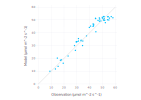

In [60]:
visualize_fit_BB(y=:Photo=>:A_net, lim=(0,60), #=title="Net Photosynthesis Rate (An)",=# pdfname="fit-BB-An")

In [61]:
calculate_fit_BB(y=:Photo=>:A_net, metric=:dr)

Progress: 100%[=========================================] Time: 0:00:04


0.8794933258671701

In [62]:
calculate_fit_BB(y=:Photo=>:A_net, metric=:ef)

0.9413359496870846

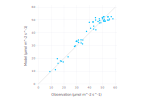

In [63]:
visualize_fit_MED(y=:Photo=>:A_net, lim=(0,60), #=title="Net Photosynthesis Rate (An)",=# pdfname="fit-MED-An")

In [64]:
calculate_fit_MED(y=:Photo=>:A_net, metric=:dr)

Progress: 100%[=========================================] Time: 0:00:01


0.8811500387281738

In [65]:
calculate_fit_MED(y=:Photo=>:A_net, metric=:ef)

0.9369503646205687

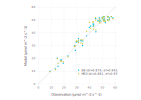

In [66]:
visualize_fits([
    (system=GasExchangeBallBerry, configs=bb_obs_configs),
    (system=GasExchangeMedlyn, configs=med_obs_configs),
];
    names=["BB (dr=0.879, ef=0.941)", "MED (dr=0.881, ef=0.937)"],
    y=:Photo=>:A_net, lim=(0,60),
    #legendpos=(0.1,-0.3),
    legendpos=(0.5,0.3),
    pdfname="fit-BB-MED-An",
    index = :CO2S=>:CO2
)

#### Stomatal Conductance

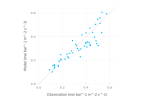

In [67]:
visualize_fit_BB(y=:gs_o=>:gs, lim=(0,0.65), #=title="Stomatal Conductance (gs)",=# pdfname="fit-BB-gs")

In [68]:
calculate_fit_BB(y=:gs_o=>:gs, metric=:dr)

0.8041928949860855

In [69]:
calculate_fit_BB(y=:gs_o=>:gs, metric=:ef)

0.7979190446067601

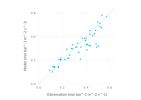

In [70]:
visualize_fit_MED(y=:gs_o=>:gs, lim=(0,0.65), #=title="Stomatal Conductance (gs)",=# pdfname="fit-MED-gs")

In [71]:
calculate_fit_MED(y=:gs_o=>:gs, metric=:dr)

0.8203325473281287

In [72]:
calculate_fit_MED(y=:gs_o=>:gs, metric=:ef)

0.7963563941026747

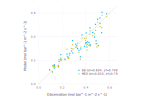

In [73]:
visualize_fits([
    (system=GasExchangeBallBerry, configs=bb_obs_configs),
    (system=GasExchangeMedlyn, configs=med_obs_configs),
];
    names=["BB (dr=0.804, ef=0.798)", "MED (dr=0.820, ef=0.796)"],
    y=:gs_o=>:gs, lim=(0,0.65),
    legendpos=(0.5,0.3),
    pdfname="fit-BB-MED-gs",
    index = :CO2S=>:CO2
)

#### Temperature

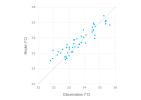

In [74]:
visualize_fit_BB(y=:Tleaf=>:T, lim=(31,36), pdfname="fit-BB-Tl")

In [75]:
calculate_fit_BB(y=:Tleaf=>:T, metric=:dr)

0.801645780581075

In [76]:
calculate_fit_BB(y=:Tleaf=>:T, metric=:ef)

0.8181630317268521

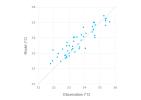

In [77]:
visualize_fit_MED(y=:Tleaf=>:T, lim=(31,36), pdfname="fit-MED-Tl")

In [78]:
calculate_fit_MED(y=:Tleaf=>:T, metric=:dr)

0.7933727943360174

In [79]:
calculate_fit_MED(y=:Tleaf=>:T, metric=:ef)

0.8026089064996039

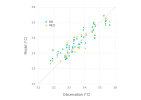

In [80]:
visualize_fits([
    (system=GasExchangeBallBerry, configs=bb_obs_configs),
    (system=GasExchangeMedlyn, configs=med_obs_configs),
];
    names=["BB", "MED"],
    y=:Tleaf=>:T, lim=(31,36),
    legendpos=(0.1,-0.3),
    pdfname="fit-BB-MED-T",
    index = :CO2S=>:CO2
)

## Analysis

In [81]:
co2_xstep = :Weather => :CO2 => 10:10:1500

:Weather => (:CO2 => 10:10:1500)

In [82]:
visualize_model(S::Type{<:GasExchange};
    config=(),
    configΔ=(),
    x=:Ca,
    y=:A_net,
    group,
    xstep=co2_xstep,
    kind=:line,
    pdfname=nothing,
    kwargs...
) = begin
    p = visualize(S, x, y; config=(config, configΔ), group=group, xstep=xstep, kind=kind, kwargs...)
    !isnothing(pdfname) && p' |> Gadfly.PDF("$pdfname.pdf")
    p' |> Gadfly.SVG()
end

visualize_model (generic function with 1 method)

In [83]:
visualize_model_BB(; config=bb_config, kw...) = visualize_model(GasExchangeBallBerry; config=config, kw...)
visualize_model_MED(; config=med_config, kw...) = visualize_model(GasExchangeMedlyn; config=config, kw...)
visualize_model(; kw...) = visualize_model_MED(; kw...)

visualize_model (generic function with 2 methods)

### Ball-Berry vs. Medlyn

#### Photosynthesis

##### Ca

In [84]:
rh_group = :Weather => :RH => 80:-20:20
rh_xstep = :Weather => :RH => 0:1:100

:Weather => (:RH => 0:1:100)

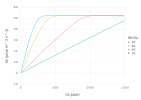

In [85]:
visualize_model_BB(group=rh_group,
    x=:Ca, y=:A_net, ylab="An", xlim=(0,1500), ylim=(-10,60), pdfname="BB-Ca-An-RH")

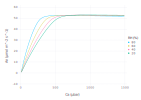

In [86]:
visualize_model_MED(group=rh_group,
    x=:Ca, y=:A_net, ylab="An", xlim=(0,1500), ylim=(-10,60), pdfname="MED-Ca-An-RH")

##### Ci

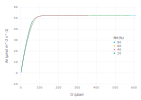

In [87]:
visualize_model_BB(group=rh_group,
    legendpos=(0.8,0),
    x=:Ci, y=:A_net, ylab="An", xlim=(0,600), ylim=(-10,60), pdfname="BB-Ci-An-RH")

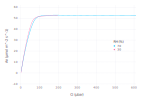

In [88]:
visualize_model_BB(group=:Weather=>:RH=>[70,30],
    legendpos=(0.8,0), colors=Gadfly.Scale.default_discrete_colors(4)[[1,3]],
    x=:Ci, y=:A_net, ylab="An", xlim=(0,600), ylim=(-10,60), pdfname="BB-Ci-An-RH")

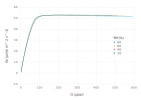

In [89]:
visualize_model_MED(group=rh_group,
    legendpos=(0.8,0),
    x=:Ci, y=:A_net, ylab="An", xlim=(0,600), ylim=(-10,60), pdfname="MED-Ci-An-RH")

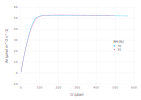

In [90]:
visualize_model_MED(group=:Weather=>:RH=>[70,30],
    legendpos=(0.8,0), colors=Gadfly.Scale.default_discrete_colors(4)[[1,3]],
    x=:Ci, y=:A_net, ylab="An", xlim=(0,600), ylim=(-10,60), pdfname="MED-Ci-An-RH")

##### Ta

In [91]:
ta_xstep = :Weather => :T_air => 0:1:50

:Weather => (:T_air => 0:1:50)

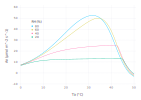

In [92]:
visualize_model_BB(group=rh_group, xstep=ta_xstep,
    legendpos=(0.1,-0.2),
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", xlim=(0,50), ylim=(-10,60), pdfname="BB-T-An-RH")

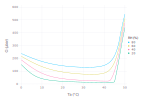

In [93]:
visualize_model_BB(group=rh_group, xstep=ta_xstep,
    x=:T_air, y=:Ci, xlab="Ta", xlim=(0,50), ylim=(0,600), pdfname="BB-T-Ci-RH")

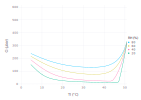

In [94]:
visualize_model_BB(group=rh_group, xstep=ta_xstep,
    x=:T, y=:Ci, xlab="Tl", xlim=(0,50), ylim=(0,600), pdfname="BB-Tl-Ci-RH")

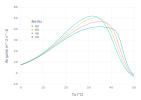

In [95]:
visualize_model_MED(group=rh_group, xstep=ta_xstep,
    legendpos=(0.1,-0.2),
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", xlim=(0,50), ylim=(-10,60), pdfname="MED-T-An-RH")

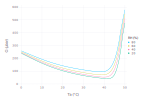

In [96]:
visualize_model_MED(group=rh_group, xstep=ta_xstep,
    x=:T_air, y=:Ci, xlab="Ta", xlim=(0,50), ylim=(0,600), pdfname="MED-T-Ci-RH")

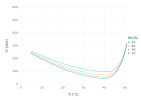

In [97]:
visualize_model_MED(group=rh_group, xstep=ta_xstep,
    x=:T, y=:Ci, xlab="Tl", xlim=(0,50), ylim=(0,600), pdfname="MED-Tl-Ci-RH")

##### RH

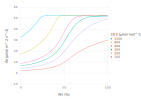

In [98]:
visualize_model_BB(group=:Weather=>:CO2=>[1500,800,400,300,200,100], xstep=rh_xstep,
    x=:RH, y=:A_net, ylab="An", xlim=(0,100), ylim=(-10,60), pdfname="BB-RH-An-CO2")

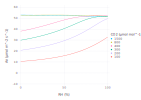

In [99]:
visualize_model_MED(group=:Weather=>:CO2=>[1500,800,400,300,200,100], xstep=rh_xstep,
    x=:RH, y=:A_net, ylab="An", xlim=(0,100), ylim=(-10,60), pdfname="MED-RH-An-CO2")

#### Stomatal Conductance

##### Ca

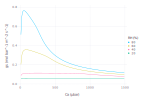

In [100]:
visualize_model_BB(group=rh_group,
    x=:Ca, y=:gs, xlim=(0,1500), ylim=(0,0.8), pdfname="BB-Ca-gs-RH")

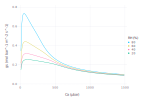

In [101]:
visualize_model_MED(group=rh_group,
    x=:Ca, y=:gs, xlim=(0,1500), ylim=(0,0.8), pdfname="MED-Ca-gs-RH")

##### Ci

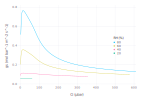

In [102]:
visualize_model_BB(group=rh_group,
    legendpos=(0.8,0),
    x=:Ci, y=:gs, xlim=(0,600), ylim=(0,0.8), pdfname="BB-Ci-gs-RH")

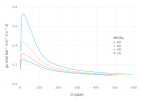

In [103]:
visualize_model_MED(group=rh_group,
    legendpos=(0.8,0),
    x=:Ci, y=:gs, xlim=(0,600), ylim=(0,0.8), pdfname="MED-Ci-gs-RH")

##### Ta

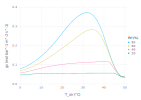

In [104]:
visualize_model_BB(group=rh_group, xstep=ta_xstep,
    x=:T_air, y=:gs, xlim=(0,50), ylim=(0,0.4), pdfname="BB-T-gs-RH")

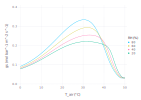

In [105]:
visualize_model_MED(group=rh_group, xstep=ta_xstep,
    x=:T_air, y=:gs, xlim=(0,50), ylim=(0,0.4), pdfname="MED-T-gs-RH")

##### RH

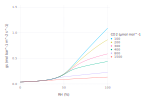

In [106]:
visualize_model_BB(group=:Weather=>:CO2=>[100,200,300,400,800,1500], xstep=rh_xstep,
    x=:RH, y=:gs, xlim=(0,100), ylim=(0,1.5), pdfname="BB-RH-gs-CO2")

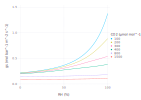

In [107]:
visualize_model_MED(group=:Weather=>:CO2=>[100,200,300,400,800,1500], xstep=rh_xstep,
    x=:RH, y=:gs, xlim=(0,100), ylim=(0,1.5), pdfname="MED-RH-gs-CO2")

#### Surface Humidity

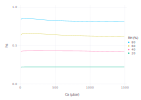

In [108]:
visualize_model_BB(group=rh_group,
    x=:Ca, y=:hs, xlim=(0,1500), ylim=(0,1), pdfname="BB-Ca-hs-RH")

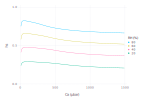

In [109]:
visualize_model_MED(group=rh_group,
    x=:Ca, y=:hs, xlim=(0,1500), ylim=(0,1), pdfname="MED-Ca-hs-RH")

#### Leaf Temperature

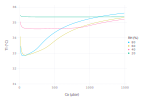

In [110]:
visualize_model_BB(group=rh_group,
    x=:Ca, y=:T, ylab="Tl", xlim=(0,1500), ylim=(31,36), pdfname="BB-Ca-Tl-RH")

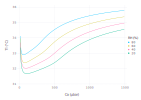

In [111]:
visualize_model_MED(group=rh_group,
    x=:Ca, y=:T, ylab="Tl", xlim=(0,1500), ylim=(31,36), pdfname="MED-Ca-Tl-RH")

## Stress Response

### Nitrogen Stress

In [112]:
nitrogen_group = :Nitrogen => :N => 2:-0.5:0.5
nitrogen_xstep = :Nitrogen => :N => 0.5:0.01:2.0;

#### Relative Humidity

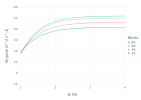

In [113]:
visualize_model_MED(group=rh_group, xstep=nitrogen_xstep,
    x=:Np, y=:A_net, xlab="N", ylab="An", ylim=(-10,60), pdfname="MED-N-An-RH")

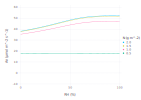

In [114]:
visualize_model_MED(group=nitrogen_group, xstep=rh_xstep, legend="N", #=names=:Np,=#
    x=:RH, y=:A_net, ylab="An", xlim=(0,100), ylim=(-10,60), pdfname="MED-N-RH-An")

#### CO2

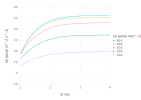

In [115]:
visualize_model_MED(group=:Weather=>:CO2=>[800,400,300,200,100], xstep=nitrogen_xstep,
    x=:Np, y=:A_net, xlab="N", ylab="An", legend="Ca", ylim=(-10,60), pdfname="MED-N-An-Ca")

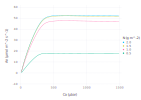

In [116]:
visualize_model_MED(group=nitrogen_group, xstep=co2_xstep, legend="N", #= names=:Np, =#
    x=:Ca, y=:A_net, ylab="An", xlim=(0,1500), ylim=(-10,60), pdfname="MED-N-Ca-An")

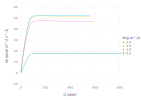

In [117]:
visualize_model_MED(group=nitrogen_group, xstep=co2_xstep, legend="N", #= names=:Np, =#
    x=:Ci, y=:A_net, ylab="An", xlim=(0,800), ylim=(-10,60), pdfname="MED-N-Ci-An")

#### Air Temperature

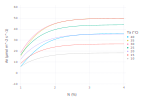

In [118]:
visualize_model_MED(group=:Weather=>:T_air=>40:-5:10, xstep=nitrogen_xstep,
    x=:Np, y=:A_net, xlab="N", ylab="An", legend="Ta", ylim=(-10,60), pdfname="MED-N-An-Ta")

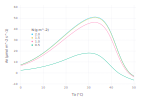

In [119]:
visualize_model_MED(group=nitrogen_group, xstep=ta_xstep,
    legend="N", legendpos=(0.1,-0.1), #= names=:Np, =#
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", xlim=(0,50), ylim=(-10,60), pdfname="MED-N-Ta-An")

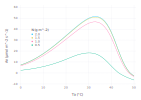

In [120]:
visualize_model_BB(group=nitrogen_group, xstep=ta_xstep,
    legend="N", legendpos=(0.1,-0.1), #= names=:Np, =#
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", xlim=(0,50), ylim=(-10,60), pdfname="BB-N-Ta-An")

#### Irradiance

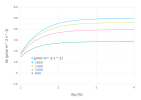

In [121]:
visualize_model_MED(group=:Weather=>:PFD=>1800:-400:600, xstep=nitrogen_xstep,
    legendpos=(0.1,0.25),
    x=:Np, y=:A_net, xlab="Np", ylab="An", legend="I", ylim=(-10,60), pdfname="MED-N-An-I")

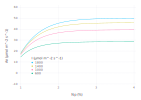

In [122]:
visualize_model_BB(group=:Weather=>:PFD=>1800:-400:600, xstep=nitrogen_xstep,
    legendpos=(0.1,0.25),
    x=:Np, y=:A_net, xlab="Np", ylab="An", legend="I", ylim=(-10,60), pdfname="BB-N-An-I")

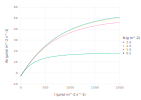

In [123]:
visualize_model_MED(group=nitrogen_group, xstep=:Weather=>:PFD=>0:10:2000, legend="N", #= names=:Np, =#
    x=:PFD, y=:A_net, xlab="I", ylab="An", xlim=(0,2000), ylim=(-10,60), pdfname="MED-N-I-An")

### Water Stress

In [124]:
water_group = :StomataTuzet => :WP_leaf => 0:-0.5:-2
water_xstep = :StomataTuzet => :WP_leaf => -2:0.02:0;

#### Relative Humidity

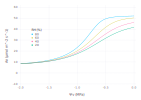

In [125]:
visualize_model_MED(group=rh_group, xstep=water_xstep,
    legendpos=(0.1,-0.1),
    x=:WP_leaf, y=:A_net, xlab="Ψv", ylab="An", ylim=(-10,60), pdfname="MED-Ψ-An-RH")

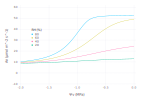

In [126]:
visualize_model_BB(group=rh_group, xstep=water_xstep,
    legendpos=(0.1,-0.1),
    x=:WP_leaf, y=:A_net, xlab="Ψv", ylab="An", ylim=(-10,60), pdfname="BB-Ψ-An-RH")

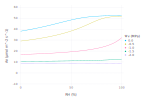

In [127]:
visualize_model_MED(group=water_group, xstep=rh_xstep,
    x=:RH, y=:A_net, ylab="An", legend="Ψv", xlim=(0,100), ylim=(-10,60), pdfname="MED-Ψ-RH-An")

#### CO2

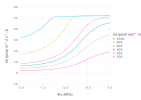

In [128]:
visualize_model_MED(group=:Weather=>:CO2=>[1500,800,400,300,200,100], xstep=water_xstep,
    x=:WP_leaf, y=:A_net, xlab="Ψv", ylab="An", legend="Ca", ylim=(-10,60), pdfname="MED-Ψ-An-Ca")

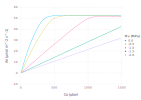

In [129]:
visualize_model_MED(group=water_group, xstep=co2_xstep,
    x=:Ca, y=:A_net, ylab="An", legend="Ψv", xlim=(0,1500), ylim=(-10,60), pdfname="MED-Ψ-Ca-An")

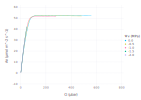

In [130]:
visualize_model_MED(group=water_group, xstep=co2_xstep,
    x=:Ci, y=:A_net, ylab="An", legend="Ψv", xlim=(0,800), ylim=(-10,60), pdfname="MED-Ψ-Ci-An")

#### Air Temperature

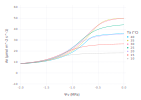

In [131]:
visualize_model_MED(group=:Weather=>:T_air=>40:-5:10, xstep=water_xstep,
    x=:WP_leaf, y=:A_net, xlab="Ψv", ylab="An", legend="Ta", ylim=(-10,60), pdfname="MED-Ψ-An-Ta")

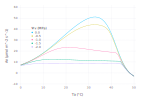

In [132]:
visualize_model_MED(group=water_group, xstep=ta_xstep,
    legendpos=(0.1,-0.1),
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", legend="Ψv", xlim=(0,50), ylim=(-10,60), pdfname="MED-Ψ-Ta-An")

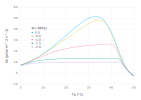

In [133]:
visualize_model_BB(group=water_group, xstep=ta_xstep,
    legendpos=(0.1,-0.1),
    x=:T_air, y=:A_net, xlab="Ta", ylab="An", legend="Ψv", xlim=(0,50), ylim=(-10,60), pdfname="BB-Ψ-Ta-An")

#### Irradiance

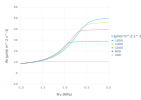

In [134]:
visualize_model_MED(group=:Weather=>:PFD=>1800:-400:200, xstep=water_xstep,
    x=:WP_leaf, y=:A_net, xlab="Ψv", ylab="An", legend="I", ylim=(-10,60), pdfname="MED-Ψ-An-I")

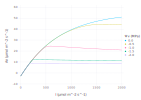

In [135]:
visualize_model_MED(group=water_group, xstep=:Weather=>:PFD=>0:10:2000,
    x=:PFD, y=:A_net, xlab="I", ylab="An", legend="Ψv", xlim=(0,2000), ylim=(-10,60), pdfname="MED-Ψ-I-An")

## Stress Interaction

In [136]:
visualize_stress(S::Type{<:GasExchange};
    config=(),
    configΔ=(),
    x=:Np,
    y=:WP_leaf,
    z=:A_net,
    xstep=:Nitrogen=>:N=>1:0.02:2,
    ystep=:StomataTuzet=>:WP_leaf=>-2:0.04:0,
    kind=:contour, #:heatmap,
    legend=false,
    aspect=1,
    pdfname=nothing,
    kwargs...
) = begin
    p = visualize(S, x, y, z; config=(config, configΔ), kind, xstep, ystep, legend, aspect, kwargs...)
    !isnothing(pdfname) && p' |> Gadfly.PDF("$pdfname.pdf", 10*Gadfly.cm)
    p' |> Gadfly.SVG()
end

visualize_stress (generic function with 1 method)

In [137]:
visualize_stress_BB(; config=bb_config, kw...) = visualize_stress(GasExchangeBallBerry; config=config, kw...)
visualize_stress_MED(; config=med_config, kw...) = visualize_stress(GasExchangeMedlyn; config=config, kw...)
visualize_stress(; kw...) = visualize_stress_MED(; kw...)

visualize_stress (generic function with 2 methods)

### RH

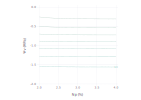

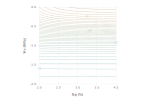

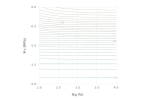

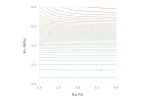

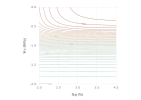

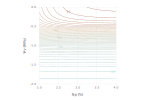

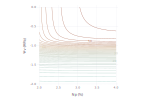

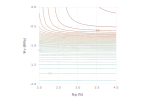

In [138]:
for x in (30, 50, 70, 90)
    visualize_stress_BB(
        configΔ=:Weather=>:RH=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="BB-NxΨ-RH-$x"
    )
    visualize_stress_MED(
        configΔ=:Weather=>:RH=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="MED-NxΨ-RH-$x"
    )
end

### CO2

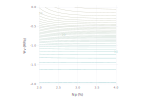

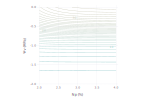

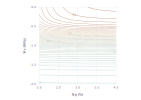

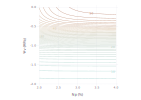

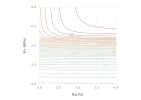

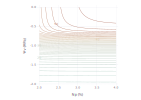

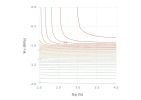

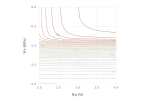

In [139]:
for x in (200, 400, 600, 800)
    visualize_stress_BB(
        configΔ=:Weather=>:CO2=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="BB-NxΨ-Ca-$x"
    )
    visualize_stress_MED(
        configΔ=:Weather=>:CO2=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="MED-NxΨ-Ca-$x"
    )
end

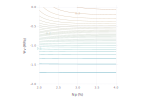

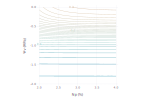

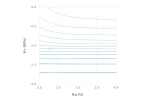

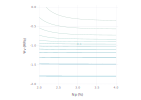

In [140]:
for x in (400, 800)
    visualize_stress_BB(
        configΔ=:Weather=>:CO2=>x,
        z=:gs,
        xlab="Np", ylab="Ψv", zlim=(0,0.4), zgap=0.01, zlabgap=0.1,
        #pdfname="BB-NxΨ-gs-Ca-$x"
    )
    visualize_stress_MED(
        configΔ=:Weather=>:CO2=>x,
        z=:gs,
        xlab="Np", ylab="Ψv", zlim=(0,0.4), zgap=0.01, zlabgap=0.1,
        #pdfname="MED-NxΨ-gs-Ca-$x"
    )
end

### PFD

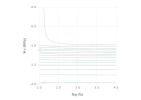

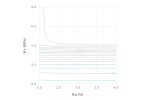

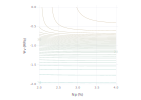

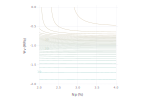

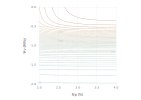

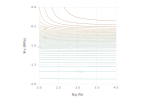

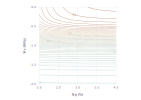

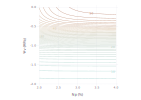

In [141]:
for x in (500, 1000, 1500, 2000)
    visualize_stress_BB(
        configΔ=:Weather=>:PFD=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="BB-NxΨ-I-$x"
    )
    visualize_stress_MED(
        configΔ=:Weather=>:PFD=>x,
        xlab="Np", ylab="Ψv", zlab="An", zlim=(-10,60), zgap=1, zlabgap=10,
        pdfname="MED-NxΨ-I-$x"
    )
end

## Extras

### Nitrogen Parameter Sensitivty

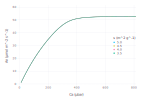

In [142]:
visualize_model(group=:NitrogenDependence=>:s=>5.0:-0.5:3.5,
    legendpos=(0.8,0),
    x=:Ca, y=:A_net, ylab="An", xlim=(0,800), ylim=(0,60), pdfname="sen-N-Ca-An-s")

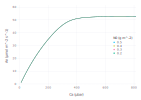

In [143]:
visualize_model(group=:NitrogenDependence=>:N0=>0.5:-0.1:0.2,
    legendpos=(0.8,0),
    x=:Ca, y=:A_net, ylab="An", xlim=(0,800), ylim=(0,60), pdfname="sen-N-Ca-An-N0")

### Kubien Replicates

In [144]:
@system WeatherVPD(Weather) begin
    VPD: vapor_pressure_deficit ~ preserve(u"kPa", parameter)
    RH(T_air, VPD, RH=vp.RH): relative_humidity => RH(T_air, VPD) * 100 ~ track(u"percent")
end

WeatherVPD

In [145]:
@system GasExchangeBallBerry2(GasExchangeBallBerry, WeatherVPD, Controller) <: GasExchange

GasExchangeBallBerry2

In [146]:
@system GasExchangeMedlyn2(GasExchangeMedlyn, WeatherVPD, Controller) <: GasExchange

GasExchangeMedlyn2

In [147]:
Kubien = (
    :C4 => (
        :Om => 200,
    ),
    :Weather => (
        :PFD => 1500,
        :CO2 => 370,
        :VPD => 12u"mbar",
    )
);

In [148]:
KubienWT = (Kubien, (
    :C4 => (
        :Vcm25 => 13.2 * 3.9, # 51.48
        :EaVc => 56.1,
        :Vpm25 => 159.9,
        :EaVp => 71.6,
    )
));

In [149]:
KubienAR1 = (Kubien, (
    :C4 => (
        :Vcm25 => 6.5 * 3.8, # 24.7
        :EaVc => 57.0,
        :Vpm25 => 186.3,
        :EaVp => 69.4,
    )
));

In [150]:
KubienAR2 = (Kubien, (
    :C4 => (
        :Vcm25 => 4.2 * 3.7, # 15.54
        :EaVc => 59.3,
        :Vpm25 => 146.9,
        :EaVp => 74.0,
    )
));

In [151]:
KubienPatch = @config(
    (:StomataBallBerry => :g0 => 0.138) +
    (:StomataMedlyn => :g0 => 0.138) +
    !(:C4 => :Jm25 => [300, 240, 120])
);

#### Initial

##### Ball-Berry

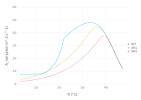

In [152]:
visualize(GasExchangeBallBerry2, :T, :A_net, config=bb_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,60), kind=:line, names=["WT", "AR1", "AR2"])

In [153]:
ans' |> Gadfly.PDF("BB-Tl-An-Kubien.pdf")

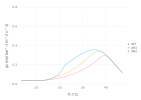

In [154]:
visualize(GasExchangeBallBerry2, :T, :gs, config=bb_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,0.8), kind=:line, names=["WT", "AR1", "AR2"])

In [155]:
ans' |> Gadfly.PDF("BB-Tl-gs-Kubien.pdf")

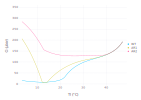

In [156]:
visualize(GasExchangeBallBerry2, :T, :Ci, config=bb_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,350), kind=:line, names=["WT", "AR1", "AR2"])

In [157]:
ans' |> Gadfly.PDF("BB-Tl-Ci-Kubien.pdf")

##### Medlyn

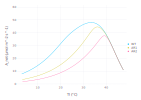

In [158]:
visualize(GasExchangeMedlyn2, :T, :A_net, config=med_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,60), kind=:line, names=["WT", "AR1", "AR2"])

In [159]:
ans' |> Gadfly.PDF("MED-Tl-An-Kubien.pdf")

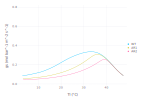

In [160]:
visualize(GasExchangeMedlyn2, :T, :gs, config=med_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,0.8), kind=:line, names=["WT", "AR1", "AR2"])

In [161]:
ans' |> Gadfly.PDF("MED-Tl-gs-Kubien.pdf")

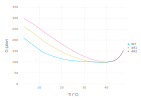

In [162]:
visualize(GasExchangeMedlyn2, :T, :Ci, config=med_config,
    group=[KubienWT, KubienAR1, KubienAR2],
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,350), kind=:line, names=["WT", "AR1", "AR2"])

In [163]:
ans' |> Gadfly.PDF("MED-Tl-Ci-Kubien.pdf")

#### Final

In [164]:
obs_kubien = CSV.read("obs-kubien.csv", DataFrame) |> unitfy

72×5 DataFrame
 Row │ treatment  Tl          A_net                   gs          Ci           ⋯
     │ String3    Quantity…   Quantity…?              Quantity…?  Quantity…?   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ WT         6.45102 °C  4.54303 μmol m^-2 s^-1     missing       missing ⋯
   2 │ WT         10.0955 °C  8.60488 μmol m^-2 s^-1     missing       missing
   3 │ WT         14.9946 °C  15.4844 μmol m^-2 s^-1     missing       missing
   4 │ WT         20.2272 °C  23.7743 μmol m^-2 s^-1     missing       missing
   5 │ WT         25.2289 °C  32.3375 μmol m^-2 s^-1     missing       missing ⋯
   6 │ WT         30.1862 °C  46.7812 μmol m^-2 s^-1     missing       missing
   7 │ WT         35.3828 °C  51.7283 μmol m^-2 s^-1     missing       missing
   8 │ WT         40.1409 °C  45.2301 μmol m^-2 s^-1     missing       missing
   9 │ AR1        6.27395 °C  1.71171 μmol m^-2 s^-1     missing       missing ⋯
  10 │ AR1        10.0958 °C  3.87387 μmol m^-2 s^-1     missing       missing
  11 │ AR1        15.0575 °C  7.71772 μmol m^-2 s^-1     missing       missing
  ⋮  │     ⋮          ⋮                 ⋮                 ⋮            ⋮       ⋱
  63 │ AR1        35.1869 °C                 missing     missing  235.533 μbar
  64 │ AR1        40.1296 °C                 missing     missing  279.418 μbar ⋯
  65 │ AR2         6.2883 °C                 missing     missing  358.811 μbar
  66 │ AR2        10.1774 °C                 missing     missing  343.094 μbar
  67 │ AR2        15.1383 °C                 missing     missing  318.163 μbar
  68 │ AR2        20.2653 °C                 missing     missing  285.812 μbar ⋯
  69 │ AR2        25.3629 °C                 missing     missing  272.352 μbar
  70 │ AR2        30.2909 °C                 missing     missing  250.344 μbar
  71 │ AR2        35.4304 °C                 missing     missing  273.991 μbar
  72 │ AR2        40.3013 °C                 missing     missing  296.736 μbar ⋯
                                                                51 rows omitted

In [165]:
visualize_kubien(S::Type{<:GasExchange}, x, y, df; pdfname=nothing, kwargs...) = begin
    p = visualize(S, x, y; kwargs...)
    plot!(p, @where(df, :treatment .== "WT"), :Tl, y, name="", color=1)
    plot!(p, @where(df, :treatment .== "AR1"), :Tl, y, name="", color=2)
    plot!(p, @where(df, :treatment .== "AR2"), :Tl, y, name="", color=3)
    !isnothing(pdfname) && p' |> Gadfly.PDF("$pdfname.pdf")
    p' |> Gadfly.SVG()
end

visualize_kubien (generic function with 1 method)

##### Ball-Berry

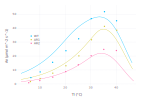

In [166]:
visualize_kubien(GasExchangeBallBerry2, :T, :A_net, obs_kubien; config=bb_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylab="An", ylim=(0,55), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.1,-0.1),
    pdfname="BB-Tl-An-Kubien-patch")

In [167]:
press = 100u"kPa"
obs_kubien.gs = obs_kubien.gs/press .|> u"mol/m^2/s/bar";

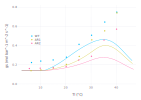

In [168]:
visualize_kubien(GasExchangeBallBerry2, :T, :gs, obs_kubien; config=bb_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,0.8), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.1,-0.1),
    pdfname="BB-Tl-gs-Kubien-patch")

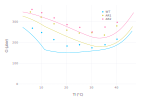

In [169]:
visualize_kubien(GasExchangeBallBerry2, :T, :Ci, obs_kubien; config=bb_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,370), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.7,-0.4),
    pdfname="BB-Tl-Ci-Kubien-patch")

##### Medlyn

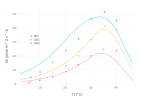

In [170]:
visualize_kubien(GasExchangeMedlyn2, :T, :A_net, obs_kubien; config=med_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylab="An", ylim=(0,55), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.1,-0.1),
    pdfname="MED-Tl-An-Kubien-patch")

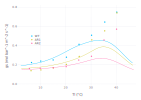

In [171]:
visualize_kubien(GasExchangeMedlyn2, :T, :gs, obs_kubien; config=med_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(0,0.8), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.1,-0.1),
    pdfname="MED-Tl-gs-Kubien-patch")

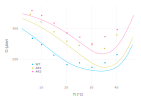

In [172]:
visualize_kubien(GasExchangeMedlyn2, :T, :Ci, obs_kubien; config=med_config,
    group=@config([KubienWT, KubienAR1, KubienAR2] + KubienPatch),
    xstep=:Weather=>:T_air=>0:0.2:45,
    xlab="Tl", ylim=(120,370), kind=:line, names=["WT", "AR1", "AR2"],
    legendpos=(0.1,0.25),
    pdfname="MED-Tl-Ci-Kubien-patch")

### Sample Code

In [173]:
Cropbox.writecodehtml("energy-balance.html", """
@system EnergyBalance(Weather) begin
  ..
  ϵ: leaf_thermal_emissivity => 0.97 ~ preserve(parameter)
  σ: stefan_boltzmann_constant => u"σ" ~ preserve(u"W/m^2/K^4")
  λ: latent_heat_of_vaporization_at_25 => 44 ~ preserve(u"kJ/mol", parameter)
  Cp: specific_heat_of_air => 29.3 ~ preserve(u"J/mol/K", parameter)

  Δw(T, T_air, RH, ea=vp.ambient, es=vp.saturation): leaf_vapor_pressure_gradient => begin
      es(T) - ea(T_air, RH)
  end ~ track(u"kPa")
  E(gv, Δw): transpiration => gv*Δw ~ track(u"mmol/m^2/s")

  H(Cp, gh, ΔT): sensible_heat_flux => Cp*gh*ΔT ~ track(u"W/m^2")
  λE(λ, E): latent_heat_flux => λ*E ~ track(u"W/m^2")

  ΔT(R_net, H, λE): temperature_adjustment => begin
      R_net ⩵ H + λE
  end ~ bisect(lower=-10, upper=10, u"K", evalunit=u"W/m^2")

  T(T_air, ΔT): leaf_temperature => (T_air + ΔT) ~ track(u"°C")
  Tk(T): absolute_leaf_temperature ~ track(u"K")
end""")

In [174]:
Cropbox.writecodehtml("simulate.html", """
c0 = (
    :StomataMedlyn => (g0 = 0.031, g1 = 1.281),
    :NitrogenDependence => (s = 4.191, N0 = 0.343),
    .. # default configuration
)
r = simulate(GasExchangeMedlyn; config=c0)""")

In [175]:
Cropbox.writecodehtml("calibrate.html", """
obs_df = .. # data frame contains gas exchange measurements
obs_C = .. # list of configurations for each measurement
c1 = calibrate(GasExchangeMedlyn, obs_df, obs_C;
    index = [:PARi => :PFD, :CO2S => :CO2, :RH_S => :RH, :Tair => :T_air, :Press => :P_air, :SPAD],
    target = [:Photo => :A_net, :gs],
    parameters = (
        :NitrogenDependence => (s=(0, 10), N0=(0, 1)),
        :StomataMedlyn => (g0=(0, 1), g1=(0, 10)),
    ),
    metric = :prmse,
    .. # other options
)""")

In [176]:
Cropbox.writecodehtml("visualize.html", """
visualize(GasExchangeMedlyn; config=(c0, c1),
    x = :Ci, y = :gs,
    xstep = :Weather => :CO2 => 10:10:1500,
    group = :Weather => :RH => [80, 60, 40, 20],
    xlim = (0, 600), ylim = (0, 1), legendpos = (0.8, 0),
    kind = :line
)""")